## Анализ причин выжимаемости на Титанике

В качестве первого домашнего задания Вам предстоит сформулировать и проверить гипотезы о причинах выживаемости на Титанике. Необходимые данные можно найти на [GitHub](https://github.com/aleksei-riabykh/sberbank_data_analysis_06_07_21/tree/master/data/titanic) курса, описание к данным на сайте соревнований по анализу данных [Kaggle](https://www.kaggle.com/c/titanic/data). 

Критерии оценивания:
* Четко сформулированы гипотезы и выводы из них
* Гипотез не меньше 3-х
* Присутствуют кросс-признаковые гипотезы (например, процент выживаемости среди молодых женщин: пол + возраст)
* Использованы группировки `.groupby()` с агрегированием `.aggregate()`, трансформацией `.transform()` или фильтрацией  `.filter()` данных
* Присутствует визуализация
* Присутствует общий вывод исследования

In [160]:
#import lib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

cmap = cm.get_cmap('Spectral')

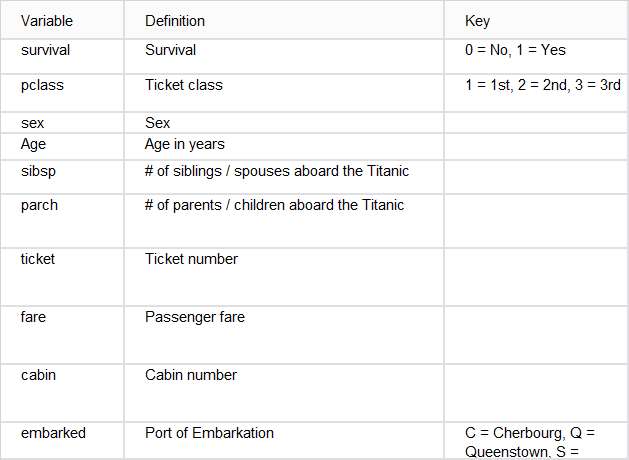

In [161]:
data = pd.read_csv("https://raw.githubusercontent.com/aleksei-riabykh/sberbank_data_analysis_06_07_21/master/data/titanic/train.csv")

In [162]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a9d6072d0>,
      dtype=object)

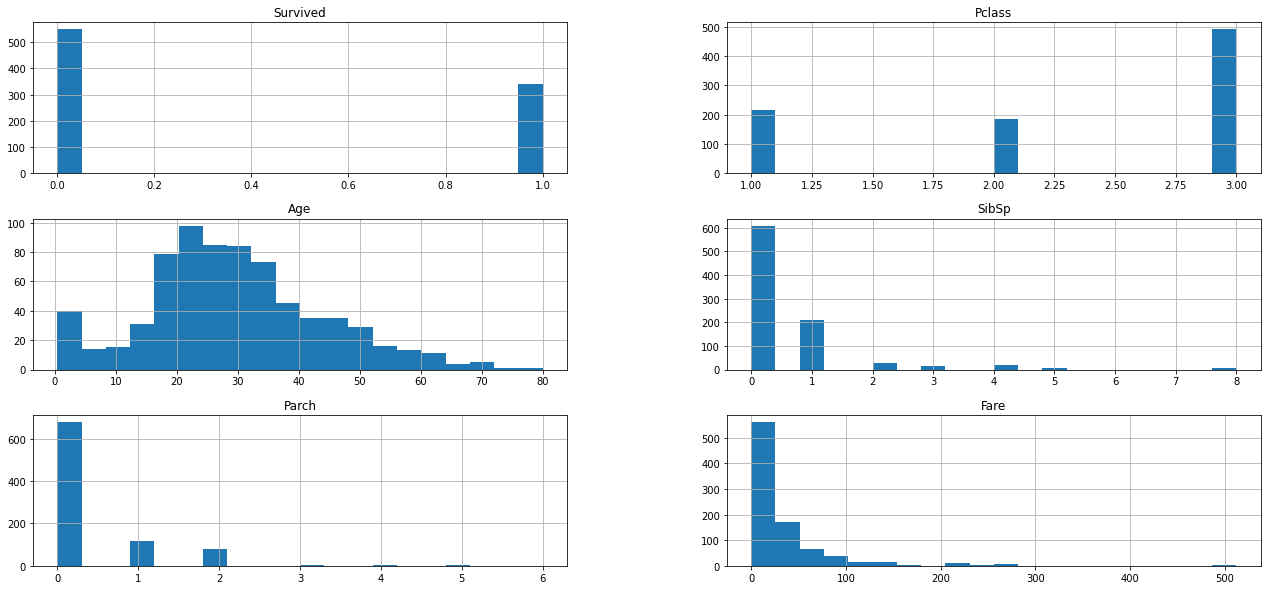

In [164]:
data[['Survived','Pclass','Age','SibSp','Parch','Fare']].hist(figsize=(22, 10), layout=(3,2), bins=20)

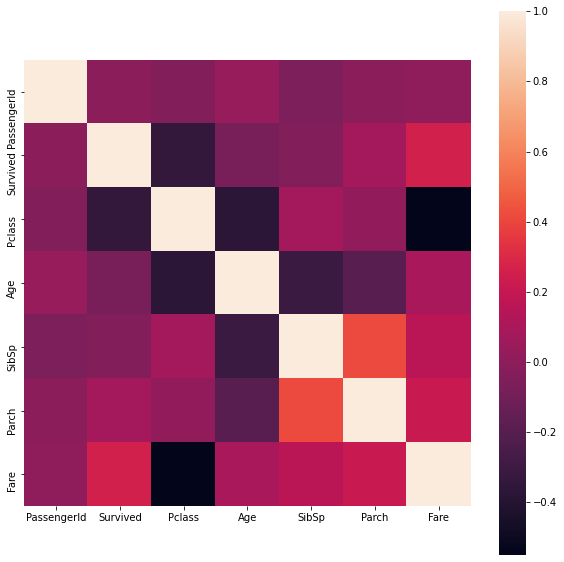

In [165]:
plt.subplots(figsize=(10,10))
sns.heatmap(data.corr(), square=True)
plt.show()

## Шаблон исследования

### Гипотеза 1

__Формулировка__: Выживаемость зависит от пола и класса пассажира

Проверим процентное соотношение выживших мужчин и женщин для каждого из классов

In [166]:
series = 100 *data.groupby(['Pclass','Sex'])['Survived'].sum() / data.groupby(['Pclass','Sex'])['PassengerId'].nunique()
series

Pclass  Sex   
1       female    96.808511
        male      36.885246
2       female    92.105263
        male      15.740741
3       female    50.000000
        male      13.544669
dtype: float64

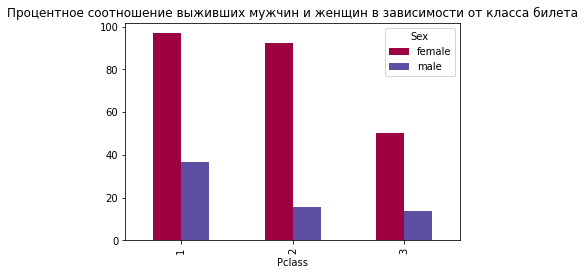

In [167]:
(100 *data.groupby(['Pclass','Sex'])['Survived'].sum() / data.groupby(['Pclass','Sex'])['PassengerId'].nunique()).unstack('Sex').plot.bar(cmap=cmap,title='Процентное соотношение выживших мужчин и женщин в зависимости от класса билета')

__Вывод__: чем выше класс, тем больше шансов выжить. При этом в процентном соотношении для каждого из классов женщин выжило больше,чем мужчин. Из шести подклассов больше всего выживших женщин из первого и второго классов.

###  Гипотеза 2

__Формулировка__: Цена купленного билета зависит от возраста пассажира

In [168]:
print("Максимальная цена билета: ", data['Fare'].max())
print("Возраст самого старого пассажира: " ,data['Age'].max())

Максимальная цена билета:  512.3292
Возраст самого старого пассажира:  80.0


Создадим категориальные переменные для возраста и цены билета

In [169]:
labels = ["cheap","medium","expensive"]
data['Fare_type'] = pd.cut(data.Fare, [0,50,150,513],labels=labels)
labels = ["infant","young","adult","older"]
data['Age_type'] = pd.cut(data.Age, [0,12,18,40,81],labels=labels)

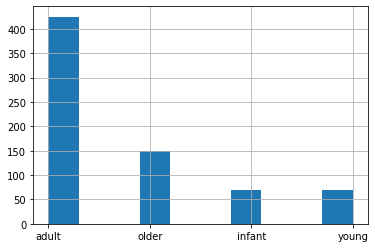

In [170]:
data['Age_type'].hist()

In [171]:
series = data.groupby(['Age_type','Fare_type'])['PassengerId'].count()/data.groupby(['Age_type'])['PassengerId'].count()
series

Age_type  Fare_type
infant    cheap        0.942029
          medium       0.028986
          expensive    0.028986
young     cheap        0.828571
          medium       0.128571
          expensive    0.042857
adult     cheap        0.804706
          medium       0.143529
          expensive    0.037647
older     cheap        0.693333
          medium       0.260000
          expensive    0.040000
Name: PassengerId, dtype: float64

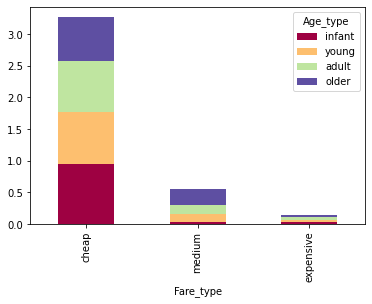

In [172]:
series.unstack(level=0).plot(kind='bar', stacked = True, cmap=cmap)

__Вывод__: Цена билета не зависела от возраста покупателя, хотя доля билетов среднего сегмента для пожилых людей была выше, чем для других ценовых диапазонов. Возможно тут неточное разбиение на интервалы для цены, так как сложно определить какой билет был дорогим в 1912 году.

### Гипотеза 3
 
__Формулировка__:

Возраст пассажиров, путешествоваших без семьи, влияет на выживаемость.  

In [173]:
#добавим признак- размер семьи на корабле (1 = пассажир путешествует один)
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

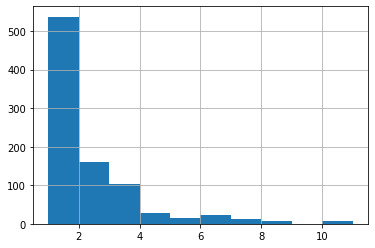

In [174]:
data['Family_Size'].hist()

In [175]:
data.loc[(data['Family_Size'] == 1)].groupby(['Age_type'])['PassengerId'].count()

Age_type
infant      2
young      34
adult     279
older      89
Name: PassengerId, dtype: int64

In [176]:
series = data.loc[(data['Family_Size'] == 1)].groupby(['Age_type'])['Survived'].sum() /data.loc[(data['Family_Size'] == 1)].groupby(['Age_type'])['PassengerId'].count()
series

Age_type
infant    0.500000
young     0.352941
adult     0.329749
older     0.280899
dtype: float64

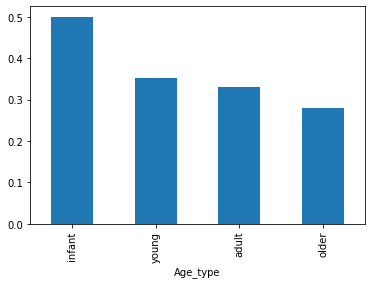

In [177]:
series.plot(kind='bar')

In [178]:
print( "Процент выживших для путешествующих без семьи: ",round(data.loc[(data['Family_Size'] == 1) & data['Survived'] ==1]['PassengerId'].count()/data.loc[(data['Family_Size'] == 1)]['PassengerId'].count(),3))

Процент выживших для путешествующих без семьи:  0.304


__Вывод__: Выживаемость для пожилых пассажиров, путешествующих одних, чуть ниже среднего значения. Для остальных возрастных групп выживаемость соответсвовала среднему значению.

### Вывод исследования:
Чем выше класс, тем больше шансов выжить.  
Женщин выжило больше, чем мужчин.  
Возраст одинкоих пассажиров практически не влияет на шансы выжить.  
Цена билета не зависела от возраста пассажира.  
  